In [1]:
import sys
import requests
import xlsxwriter
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from json import loads
from datetime import date
from dateutil.relativedelta import relativedelta

### Function for Transforming DataFrame in Excel Object

In [2]:
#Function for Writing .xlsx Data Tables which will provide a standard output for table formatting 
def xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer):

    #Layout/Formatting
    t_vert_spacing = 5 #Vertical Spacing between tables
    t_horz_spacing = 1 #Horizontal Spacing between tables
    title_format = workbook.add_format({'bold': True, 'font_size' : 20, 'fg_color' : '#76933C', 'font_color' : 'white' }) #Standardised Title Format for all tables
    header_format = workbook.add_format({'bold' : True, 'font_size' : 12, 'text_wrap' : True}) #text-wrapping for table headers

    # Rank Colouring
    white_format = workbook.add_format({'font_size' : 9,'bg_color' : '#e0e0de','font_color': 'black'})
    yellow_format = workbook.add_format({'font_size' : 9,'bg_color' : '#F4B831','font_color': 'black'})
    blue_format = workbook.add_format({'font_size' : 9,'bg_color' : '#3B7EBA','font_color': 'white'})
    purple_format = workbook.add_format({'font_size' : 9,'bg_color' : '#856DCC','font_color': 'white'})
    
    # Adding and changing active sheet
    try:
        worksheet=workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet 
        worksheet.set_zoom(70)
        startrow = 3
        startcol = 1
    except:
        pass

    for i in range(len(col_width_list)):
        worksheet.set_column(i+startcol, i+startcol, col_width_list[i])

    #Writing in Cell Data and Merging Cells for Table Titles
    data_table.to_excel(writer,sheet_name=sheet_name,startrow=startrow , startcol=startcol, index=False, header=False)
    worksheet.merge_range(startrow-2, startcol,startrow-2,data_table.shape[1] + startcol -1, title_str,title_format) #writing in title formatting above table

    #Conditional Formatting For Colors of Ranks
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'white', 'format': white_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '8 kyu', 'format': white_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '7 kyu', 'format': white_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'yellow', 'format': yellow_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '6 kyu', 'format': yellow_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '5 kyu', 'format': yellow_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'blue', 'format': blue_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '4 kyu', 'format': blue_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '3 kyu', 'format': blue_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'purple', 'format': purple_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '2 kyu', 'format': purple_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '1 kyu', 'format': purple_format}  )


    #Column settings to use in add table function
    column_settings = [{'header' : column} for column in data_table.columns]

    #Populating Excel with Table Format - Adding table to xls for each df
    worksheet.add_table(startrow-1, startcol, startrow + data_table.shape[0]-1, data_table.shape[1] + startcol - 1, {'columns' : column_settings, 'style': 'Table Style Medium 4', 'autofilter' : False})   

    #Applying a text wrap to the Column Header
    for col_num, value in enumerate(data_table.columns.values):
        worksheet.write(startrow-1, col_num + startcol, value, header_format)
    
    #Setting Positions of Following Tables Insertions
    startrow = startrow + data_table.shape[0] + t_vert_spacing #Setting to start row for next table
    # startrow = 3  
    # startcol = startcol + data_table.shape[1] + t_horz_spacing  #Disabling horizontally displaced tables in favour of vertically displacements
    startcol = 1

    #Setting the column width at the end of the table to keep to spacing minimal between tables
    worksheet.set_column(startcol-1,startcol-1,1)
    
    #Return the start row in order to index for future function calls
    return [startrow,startcol,worksheet,workbook,writer]

In [3]:
#Function to Detect Operating System and Adjust Pathing to Respective Filesystem
def pathing(folder_path,filename):

    #Windows Operating System
    if 'win' in sys.platform:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}\\{filename}'
        else:
            filepath = f'{sys.path[0]}\\{folder_path}\\{filename}'
    #Linux/Mac Operating Sytem
    else:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}/{filename}'
        else:
            filepath = f'{sys.path[0]}/{folder_path}/{filename}'

    return filepath

### User Inputs

In [4]:
user = "Filpill"

### User Overview

In [5]:
url = f"https://www.codewars.com/api/v1/users/{user}"
response = requests.get(url)
json_data = loads(response.text)
print("Status:",response.status_code)
curated_cols = ['username','honor','leaderboardPosition','ranks.overall.name','ranks.languages.python.score','ranks.languages.sql.score','ranks.overall.score','codeChallenges.totalCompleted']
df_profile = pd.json_normalize(json_data)
profile_cols = list(df_profile.columns)
df_profile = df_profile[df_profile.columns.intersection(curated_cols)]
df_profile

Status: 200


,username,honor,leaderboardPosition,ranks.overall.name,ranks.overall.score,ranks.languages.python.score,ranks.languages.sql.score,codeChallenges.totalCompleted
0,Filpill,2112,6079,3 kyu,2446,1791,655,306


### List of Completed Challenges
- Need to make a request first  to find total number of pages in order to paginate

In [6]:
url = f"https://www.codewars.com/api/v1/users/{user}/code-challenges/completed?page=0"
response = requests.get(url)
json_data = loads(response.text)
number_of_pages = json_data.get('totalPages')

#### Paginating the list of challenges

In [7]:
for page in range(number_of_pages):
    url = f"https://www.codewars.com/api/v1/users/{user}/code-challenges/completed?page={page}"
    response = requests.get(url)
    json_data = loads(response.text)
    print("Status:",response.status_code)
    raw_data = pd.json_normalize(json_data)
    df_page = pd.DataFrame.from_dict(raw_data.loc[0,'data'])
    df_page.drop(columns = 'slug',inplace=True)
    for i,dt in enumerate(df_page['completedAt']): df_page.loc[i,'completedAt'] = dt[0:10] #Fixing Date Formats, Only extracting date component
    df_page['completedAt'] = pd.to_datetime(df_page['completedAt'],format='%Y-%m-%d')
    df_page['Completion Period'] = df_page['completedAt'].dt.strftime("%b-%y")
    if page == 0:
        df_complete = df_page.copy()
    else:
        df_complete = pd.concat([df_complete,df_page])

completed_list = list(df_complete['id'])
df_complete.head(2)
df_complete.shape[0]

Status: 200
Status: 200


306

### Getting Details of Code Challenges Completed By User

In [8]:
url = f"https://www.codewars.com/api/v1/code-challenges/{completed_list[0]}"
response = requests.get(url)
json_data = loads(response.text)
details_cols =  list(pd.json_normalize(json_data).columns)
df_kata = pd.DataFrame(columns=details_cols) #Making empty dataframe with relevant columns

#Looping through all the completed challenge id's
for kata_id in completed_list:
    url = f"https://www.codewars.com/api/v1/code-challenges/{kata_id}"
    response = requests.get(url)
    json_data = loads(response.text)
    row = pd.json_normalize(json_data)
    df_kata = pd.concat([df_kata,row]) 
df_kata.head(2)

,id,name,slug,category,publishedAt,approvedAt,languages,url,createdAt,description,...,contributorsWanted,rank.id,rank.name,rank.color,createdBy.username,createdBy.url,approvedBy.username,approvedBy.url,unresolved.issues,unresolved.suggestions
0,5679aa472b8f57fb8c000047,Equal Sides Of An Array,equal-sides-of-an-array,reference,2015-12-22T22:03:35.429Z,2016-01-03T09:48:13.959Z,"[csharp, javascript, python, coffeescript, rub...",https://www.codewars.com/kata/5679aa472b8f57fb...,2015-12-22T19:53:43.525Z,You are going to be given an array of integers...,...,True,-6,6 kyu,yellow,Shivo,https://www.codewars.com/users/Shivo,g964,https://www.codewars.com/users/g964,0,4
0,55ad04714f0b468e8200001c,get character from ASCII Value,get-character-from-ascii-value,reference,2015-07-20T14:24:09.126Z,2017-02-18T18:18:09.759Z,"[ruby, javascript, coffeescript, csharp, cpp, ...",https://www.codewars.com/kata/55ad04714f0b468e...,2015-07-20T14:23:46.080Z,Write a function `get_char()` / `getChar()` wh...,...,True,-8,8 kyu,white,nakulgupta18,https://www.codewars.com/users/nakulgupta18,tachyonlabs,https://www.codewars.com/users/tachyonlabs,2,2


### Splitting Out The Details Into Lists

In [9]:
challenge_details = list(df_kata.columns)
selected_details = ['id','totalAttempts','totalCompleted','rank.name','rank.color','category','tags']
print(challenge_details)
df_details_select = df_kata[df_kata.columns.intersection(selected_details)]
df_details_select.head(2)

['id', 'name', 'slug', 'category', 'publishedAt', 'approvedAt', 'languages', 'url', 'createdAt', 'description', 'totalAttempts', 'totalCompleted', 'totalStars', 'voteScore', 'tags', 'contributorsWanted', 'rank.id', 'rank.name', 'rank.color', 'createdBy.username', 'createdBy.url', 'approvedBy.username', 'approvedBy.url', 'unresolved.issues', 'unresolved.suggestions']


,id,category,totalAttempts,totalCompleted,tags,rank.name,rank.color
0,5679aa472b8f57fb8c000047,reference,385068,91837,"[Algorithms, Arrays, Fundamentals]",6 kyu,yellow
0,55ad04714f0b468e8200001c,reference,38810,22937,[Fundamentals],8 kyu,white


### Merging Details onto Completitons via the Kata ID

In [10]:
df_kata_combined = pd.merge(df_complete,df_details_select,on='id',how='left')
df_kata_combined.head(2)

,id,name,completedLanguages,completedAt,Completion Period,category,totalAttempts,totalCompleted,tags,rank.name,rank.color
0,5679aa472b8f57fb8c000047,Equal Sides Of An Array,[python],2022-11-21,Nov-22,reference,385068,91837,"[Algorithms, Arrays, Fundamentals]",6 kyu,yellow
1,55ad04714f0b468e8200001c,get character from ASCII Value,[python],2022-11-21,Nov-22,reference,38810,22937,[Fundamentals],8 kyu,white


### Re-naming Columns

In [11]:
df_profile.rename(columns={ 'username':'Username',
                           'honor':'Honor',
                           'leaderboardPosition':'Leaderboard',
                           'ranks.overall.name':'Overall Rank',
                           'ranks.languages.python.score':'Python Score',
                           'ranks.languages.sql.score':'SQL Score',
                           'ranks.overall.score':'Total Score'
                           },inplace=True)

df_kata_combined.rename(columns={'id':'Kata ID',
                           'name':'Kata Name',
                           'completedLanguages':'Languages',
                           'completedAt':'Completed Date',
                           'category':'Category',
                           'totalAttempts':'Total Attempts',
                           'totalCompleted':'Total Completed',
                           'tags':'Tags',
                           'rank.name':'Rank',
                           'rank.color':'Color'
                           },inplace=True)
df_kata_combined.head(2)

,Kata ID,Kata Name,Languages,Completed Date,Completion Period,Category,Total Attempts,Total Completed,Tags,Rank,Color
0,5679aa472b8f57fb8c000047,Equal Sides Of An Array,[python],2022-11-21,Nov-22,reference,385068,91837,"[Algorithms, Arrays, Fundamentals]",6 kyu,yellow
1,55ad04714f0b468e8200001c,get character from ASCII Value,[python],2022-11-21,Nov-22,reference,38810,22937,[Fundamentals],8 kyu,white


### Saving merged data into csv

In [33]:
df_kata_combined.to_csv('csv/codewars_request.csv')

### Data Aggregation

In [14]:
# Creating Date Range List
date_str = date.today().strftime("%d-%b-%Y")
start_date = df_kata_combined['Completed Date'].min()
end_date = df_kata_combined['Completed Date'].max() + relativedelta(months=1)
date_rng = pd.date_range(start = start_date, end = end_date, freq = 'M').tolist()

#### Category Count

In [34]:
df_category = df_kata_combined.groupby(['Category'])['Category'].count().reset_index(name='Count')
df_category.sort_values(by=['Count'],inplace=True,ascending=False)
df_category.to_csv('csv/category.csv')
df_category

,Category,Count
4,reference,263
0,algorithms,37
2,games,3
3,refactoring,2
1,bug_fixes,1


#### Monthly Kata Completions

In [36]:
df_monthly_count = df_kata_combined.groupby(['Completed Date'])['Completed Date'].count()
df_monthly_count = df_monthly_count.groupby([pd.Grouper(level='Completed Date',freq='1M')]).sum().reset_index(name='Count')
for i,val in enumerate(date_rng): 
   df_monthly_count.loc[i,'Completed Date']  = val.strftime("%b-%y")
df_monthly_count.to_csv('csv/monthly.csv')
df_monthly_count

,Completed Date,Count
0,Jun-22,29
1,Jul-22,0
2,Aug-22,0
3,Sep-22,12
4,Oct-22,22
5,Nov-22,243


#### Rank Difficulty

In [37]:
df_rank_count = df_kata_combined.groupby(['Rank'])['Rank'].count().reset_index(name='Count')
df_rank_count.to_csv('csv/rank.csv')
df_rank_count 

,Rank,Count
0,4 kyu,15
1,5 kyu,31
2,6 kyu,62
3,7 kyu,78
4,8 kyu,120


#### Language Completions

In [38]:
# Looping through series to unpack language list into new rows
lang_comp = []
for i,lang_list in enumerate(df_kata_combined['Languages']):
    for lang in lang_list:
        lang_comp.append((df_kata_combined.loc[i,'Kata ID'],
                        df_kata_combined.loc[i,'Completed Date'],
                        lang))

# Creating seperate data frame for unpacking the programming languages
df_lang = pd.DataFrame(data=lang_comp,columns=['Kata ID','Completion Period','Languages'])
for i in range(df_lang.shape[0]): 
   df_lang.loc[i,'Completion Period']  = df_lang.loc[i,'Completion Period'].strftime("%b-%y")
   
# Applying Groupby to count number of kata completions split by language
df_lang = df_lang.groupby(['Languages'])['Languages'].count().reset_index(name='Count')
df_lang.to_csv('csv/language.csv')
df_lang

,Languages,Count
0,python,216
1,sql,90


#### Tags

In [39]:
# Looping through series to unpack tags into new rows
tag_list = []
for i,kata_tags in enumerate(df_kata_combined['Tags']):
    for tag in kata_tags:
        tag_list.append((df_kata_combined.loc[i,'Kata ID'],
                        df_kata_combined.loc[i,'Completed Date'],
                        tag))

# Creating seperate data frame for unpacking the tags
df_tags = pd.DataFrame(data=tag_list,columns=['Kata ID','Completion Period','Tags'])
for i in range(df_tags.shape[0]): 
   df_tags.loc[i,'Completion Period']  = df_tags.loc[i,'Completion Period'].strftime("%b-%y")
   
# Applying Groupby to count number of kata completions split by language
df_tags = df_tags.groupby(['Tags'])['Tags'].count().reset_index(name='Count')
df_tags.sort_values(by=['Count'],inplace=True,ascending=True)
df_tags.to_csv('csv/tags.csv')
df_tags.tail(10)

,Tags,Count
8,Data Science,11
28,Regular Expressions,11
19,Lists,11
10,Databases,29
21,Mathematics,36
3,Arrays,44
2,Algorithms,50
32,Strings,72
29,SQL,86
16,Fundamentals,258


### Data Visualisation

In [20]:
def chart_annotation(df,ax,chart_type,x_offset,y_offset):
    #Text Annotations
    [r,g,b] = [.4,.6,.85]
    [lw,pad] = [0.2,3.5]
    date_str = date.today().strftime("%d-%b-%Y")
    for i,count in enumerate(df['Count']):
        if count > 0:
            if chart_type == 'bar': 
                ax.text(i,count*0.5,count,fontsize=10,color='white',weight='bold',
                        bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')
            elif chart_type == 'barh': 
                ax.text(count*0.5,i,count,fontsize=10,color='white',weight='bold',
                        bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')

    # Positional coordinates for Data Refresh Text
    if chart_type == 'bar': 
        x_pos = df.shape[0] + x_offset
        y_pos = df['Count'].max() + y_offset
    elif chart_type == 'barh': 
        x_pos = df['Count'].max() + y_offset
        y_pos = df.shape[0] + x_offset
    ax = ax.text(x_pos,y_pos,f'Data refreshed:{date_str}',fontsize =9,horizontalalignment='right')

#### Monthly Kata Completions

In [21]:
# Border Parameters
border_size = 8
border_color = 'darkslategrey'

# Making a colormap to map onto the bar chart
def cmap_list(df):
    clist = [(0, "lightblue"), (1, "steelblue")]
    rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
    df_range = np.arange(df.shape[0]).astype(float)
    color = rvb(df_range/df.shape[0])
    return color

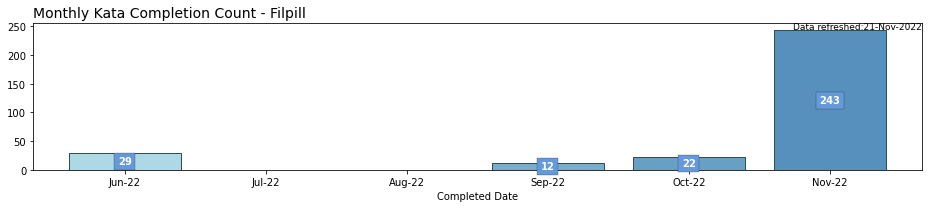

In [22]:
#Plotting a Monthly Completion Rate
fig, ax = plt.subplots(figsize=(13,3),linewidth=border_size)
chart_type = 'bar'
color = cmap_list(df_monthly_count)
ax = df_monthly_count.plot('Completed Date','Count',kind=chart_type,ax=ax,width=0.8,ec='darkslategrey',color=color)
ax.set_title(f'Monthly Kata Completion Count - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
[x_offset,y_offset] = [-0.35,2.5] #Data refresh text offset
chart_annotation(df_monthly_count,ax,chart_type,x_offset,y_offset)
plt.tight_layout()

#Saving Chart
plt.savefig('charts/monthly_complete.png',edgecolor=border_color,dpi=150)

#### Rank Difficulty

In [23]:
# Difficulty colors
white = '#e0e0de'
yellow = '#F4B831'
blue= '#3B7EBA'
purple= '#856DCC'

rank_colors ={
     '1 kyu' : purple
    ,'2 kyu' : purple
    ,'3 kyu' : blue
    ,'4 kyu' : blue
    ,'5 kyu' : yellow 
    ,'6 kyu' : yellow 
    ,'7 kyu' : white 
    ,'8 kyu' : white 
}
# Making color list for difficulties of Kata
rank_color_list =[]
unique_ranks = df_rank_count['Rank']
for rank in unique_ranks:
    rank_color_list.append(rank_colors.get(rank))

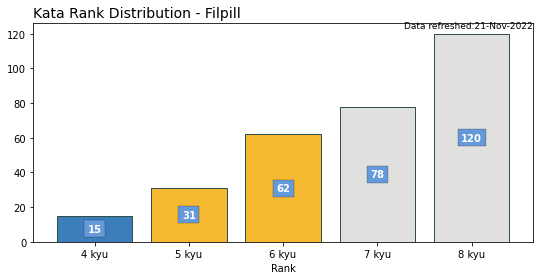

In [24]:
#Plotting Rank Completions
fig, ax = plt.subplots(figsize=(7.6,4),linewidth=border_size)
chart_type = 'bar'
ax = df_rank_count.plot('Rank','Count',kind=chart_type,ax=ax,width=0.8,ec='darkslategrey',color=rank_color_list)
ax.set_title(f'Kata Rank Distribution - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

# Text Annotations
[x_offset,y_offset] = [-0.35,3] #Data refresh text offset
chart_annotation(df_rank_count,ax,chart_type,x_offset,y_offset)

#Saving Chart
plt.savefig('charts/rank_distribution.png',edgecolor=border_color, dpi=150)

#### Languages

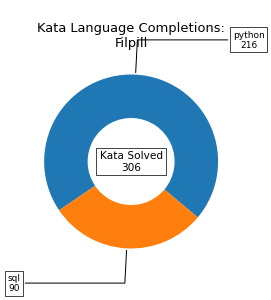

In [25]:
#Plotting a Monthly Completion Rate
fig, ax = plt.subplots(figsize=(5, 4), linewidth=border_size, subplot_kw=dict(aspect="equal"))

# Arranging Data
data = df_lang['Count']
lang_total = 0
for d in data: lang_total += d
uniques = list(set(df_lang['Languages']))
language_labels = []
for i,r in enumerate(uniques):
    language_labels.append(f'{r}\n{data[i]}')

#Setting a backround color
fig.set_facecolor('white')

# Creating pie elements
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="0", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

# Annotations
ax.set_title(f'\nKata Language Completions:\n{user}',color='black',fontsize=13)
ax.annotate(f'Kata Solved\n{lang_total}', xy=(0, 0), xytext=(0, 0),
            horizontalalignment='center',fontsize = 10.5, **kw)


for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(language_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment='center',fontsize = 9, **kw)

#Saving Chart
plt.savefig('charts/language_pie.png',edgecolor=border_color,dpi=150)

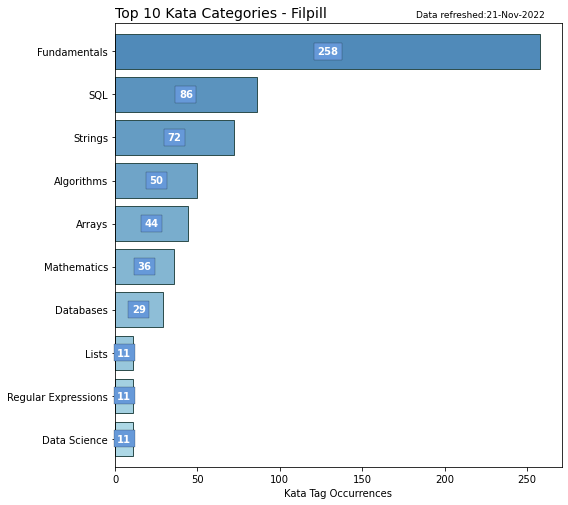

In [26]:
#Plotting Categories
number_of_tags = 10
plot_tags = df_tags.tail(number_of_tags)
color = cmap_list(plot_tags)
fig, ax = plt.subplots(figsize=(8,7.125),linewidth=border_size)
chart_type = 'barh'
ax = plot_tags.plot('Tags','Count',kind=chart_type,ax=ax,width=0.8,ec='darkslategrey',color=color)
ax.set_title(f'Top {number_of_tags} Kata Categories - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('Kata Tag Occurrences')
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

# Text Annotations
[x_offset,y_offset] = [-0.2,2.8] #Data refresh text offset
chart_annotation(plot_tags,ax,chart_type,x_offset,y_offset)

#Saving Chart
plt.savefig('charts/top_tags.png',edgecolor = border_color,dpi = 150)

### Initialising XlsxWriter Workbook And Exporting Tables to .xlsx

#### Tables

In [27]:
#-------------------------------------------------------
#-------------.xlsx workbook initialisation-------------
#-------------------------------------------------------

#Excel Output Filepath
excelpath = pathing('xlsx_data',f'codewars_stats_{user}.xlsx')

#Generating .xlsx workbook in which to record dataframes for usage.
writer = pd.ExcelWriter(excelpath,engine='xlsxwriter')   
workbook=writer.book
worksheet='' #Initialise variable
startrow = 0 #Initialise variable
startcol = 0 #Initialise variable

In [28]:
#Summary Table
data_table = df_profile
sheet_name = 'Tables'
title_str = f'{user} Codewars Stats since {date_str}'
col_width_list = [31,60,22,26,15,15,17,11,60,11,11]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,
                                                                title_str,startrow,startcol,
                                                                worksheet,workbook,writer)

In [29]:
#Summary Table
data_table = df_kata_combined
sheet_name = 'Tables'
title_str = f'Kata Compeleted By {user} since {date_str}'
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,
                                                                title_str,startrow,startcol,
                                                                worksheet,workbook,writer)

#### Dashboard/Charts

In [30]:
# Adding and changing active sheet
sheet_name = 'Dashboard'
try:
    worksheet=workbook.add_worksheet(sheet_name)
    writer.sheets[sheet_name] = worksheet 
    worksheet.set_zoom(95)
except:
    pass


In [31]:
# Positioning matplotlib charts onto xlsx dashboard
v_space = 15
worksheet.insert_image(0,0,'charts/monthly_complete.png')
worksheet.insert_image(v_space,0,'charts/language_pie.png')
worksheet.insert_image(v_space,8,'charts/rank_distribution.png')
worksheet.insert_image(0,20,'charts/top_tags.png')

0

In [32]:
#Save Excel File Close workbook instance
writer.close()